In [1]:
# Vamos a instalar y usar PySpark desde cero. Lo emplearemos junto a un prosumidor de kafka para recoger y pre-procesar datos

# Curso guiado de PySpark (interactive)
Objetivos de este notebook:
- Configurar PySpark en Jupyter
- Crear `SparkSession`
- Cargar datos (ejemplo local CSV / DataFrame creado)
- Operaciones básicas: select, filter, groupBy, agregaciones
- Escritura a Parquet y explicación de particionado
- Siguientes pasos: performance, joins grandes, MLlib, streaming

**Ejecuta la siguiente celda para comprobar entorno.**


In [2]:
# Comprobaciones rápidas: versión de Python, Java y si pyspark está instalado.
import sys, subprocess, shutil, os

print("Python:", sys.version.splitlines()[0])

# Java check
java = shutil.which("java")
if java:
    try:
        out = subprocess.check_output([java, "-version"], stderr=subprocess.STDOUT)
        print(out.decode(errors='ignore').splitlines()[0])
    except Exception as e:
        print("Error ejecutando 'java -version':", e)
else:
    print("No se encontró 'java' en PATH. PySpark necesita Java (OpenJDK 8/11 recommended).")

# Pyspark installed?
try:
    import pyspark
    print("pyspark:", pyspark.__version__)
except Exception as e:
    print("pyspark no instalado. Ejecuta la celda siguiente para instalarlo (si procede).")


Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
java version "17.0.12" 2024-07-16 LTS
pyspark: 3.5.1


**Confirmaremos que está PySpark y Java al visualizar un mensaje similar a este:**
```
Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
java version "17.0.12" 2024-07-16 LTS
pyspark: 3.5.1
```

*En caso contrario revisar de nuevo el notebook de instalación (Install.ipynb)*

**Creamos un SparkSession y establecemos la cfg básica**

In [3]:
from pyspark.sql import SparkSession
import os, sys

spark = SparkSession.builder \
    .appName("MiniLLM PySpark Tutorial") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

print("SparkSession creada:", spark)
print("Master:", spark.sparkContext.master)
print("Spark version:", spark.version)


SparkSession creada: <pyspark.sql.session.SparkSession object at 0x000002318D8761A0>
Master: local[*]
Spark version: 3.5.1


*SparkSession creada: <pyspark.sql.session.SparkSession object at 0x000001A5A2489600>*

Este mensaje confirma la correcta creación. **Ahora probemos a crear un dataframe de ejemplo:**

### Asegurarnos de que Spark y los workers usan exactamente el mismo intérprete Python

In [4]:
import os, sys

# Forzar que los workers usen el mismo python que el kernel
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# Opciones útiles para debugging local
os.environ["PYSPARK_SUBMIT_ARGS"] = "--conf spark.sql.shuffle.partitions=2 pyspark-shell"

print("PYSPARK_PYTHON:", os.environ["PYSPARK_PYTHON"])
print("python executable:", sys.executable)

# Reiniciar/crear SparkSession seguro
try:
    from pyspark.sql import SparkSession
    if 'spark' in globals():
        try:
            spark.stop()
        except Exception:
            pass
    spark = SparkSession.builder \
        .master("local[2]") \
        .appName("debug_pyspark") \
        .config("spark.driver.memory", "2g") \
        .config("spark.executor.memory", "2g") \
        .config("spark.sql.shuffle.partitions", "2") \
        .getOrCreate()
    spark.sparkContext.setLogLevel("WARN")
    print("Spark started:", spark.version, spark.sparkContext.master)
except Exception as e:
    print("ERROR al crear SparkSession:", repr(e))
    raise


PYSPARK_PYTHON: C:\Users\soyko\AppData\Local\Programs\Python\Python310\python.exe
python executable: C:\Users\soyko\AppData\Local\Programs\Python\Python310\python.exe
Spark started: 3.5.1 local[2]


## Testeamos un hola mundo

In [5]:
df = spark.createDataFrame([(1,"hola"), (2," "), (3,"mundo")], ["id","v"])
print("count:", df.count())
print("collect:", df.select("v").rdd.map(lambda r: r[0].upper()).collect())
df.show()

count: 3
collect: ['HOLA', ' ', 'MUNDO']
+---+-----+
| id|    v|
+---+-----+
|  1| hola|
|  2|     |
|  3|mundo|
+---+-----+



## Crear un DataFrame pequeño desde lista (útil para entender API)

In [6]:
data = [
    ("Alice", "2025-01-01", 50.0),
    ("Bob",   "2025-01-01", 20.0),
    ("Alice", "2025-01-02", 30.0),
    ("Bob",   "2025-01-02", 40.0),
    ("Carmen","2025-01-02", 15.0)
]

columns = ["name", "date", "amount"]
df = spark.createDataFrame(data, schema=columns)
df.show()
df.printSchema()

# Operaciones: select, filter, agregaciones
from pyspark.sql import functions as F

# 1) Filtrar
df.filter(F.col("amount") > 25).show()

# 2) Agrupar por name y sumar amount
agg = df.groupBy("name").agg(
    F.count("*").alias("n_trx"),
    F.sum("amount").alias("total_amount"),
    F.avg("amount").alias("avg_amount")
).orderBy(F.desc("total_amount"))

agg.show()


+------+----------+------+
|  name|      date|amount|
+------+----------+------+
| Alice|2025-01-01|  50.0|
|   Bob|2025-01-01|  20.0|
| Alice|2025-01-02|  30.0|
|   Bob|2025-01-02|  40.0|
|Carmen|2025-01-02|  15.0|
+------+----------+------+

root
 |-- name: string (nullable = true)
 |-- date: string (nullable = true)
 |-- amount: double (nullable = true)

+-----+----------+------+
| name|      date|amount|
+-----+----------+------+
|Alice|2025-01-01|  50.0|
|Alice|2025-01-02|  30.0|
|  Bob|2025-01-02|  40.0|
+-----+----------+------+

+------+-----+------------+----------+
|  name|n_trx|total_amount|avg_amount|
+------+-----+------------+----------+
| Alice|    2|        80.0|      40.0|
|   Bob|    2|        60.0|      30.0|
|Carmen|    1|        15.0|      15.0|
+------+-----+------------+----------+



### Crea un CSV de ejemplo si no tienes uno; si tienes un archivo real, pon la ruta.

In [7]:
import pandas as pd
sample_csv = "sample_data.csv"
pd.DataFrame([
    {"name":"Alice","date":"2025-01-01","amount":50},
    {"name":"Bob","date":"2025-01-01","amount":20},
    {"name":"Carmen","date":"2025-01-03","amount":70},
]).to_csv(sample_csv, index=False)



**Leer CSV con Spark**

In [8]:
df_csv = spark.read.option("header","true").option("inferSchema","true").csv(sample_csv)
df_csv.show()
df_csv.printSchema()


+------+----------+------+
|  name|      date|amount|
+------+----------+------+
| Alice|2025-01-01|    50|
|   Bob|2025-01-01|    20|
|Carmen|2025-01-03|    70|
+------+----------+------+

root
 |-- name: string (nullable = true)
 |-- date: date (nullable = true)
 |-- amount: integer (nullable = true)



**Operaciones: contar, describir**

In [9]:
print("Count:", df_csv.count())
df_csv.describe("amount").show()

Count: 3
+-------+------------------+
|summary|            amount|
+-------+------------------+
|  count|                 3|
|   mean|46.666666666666664|
| stddev|25.166114784235834|
|    min|                20|
|    max|                70|
+-------+------------------+



### Escribir a parquet localmente (particionado por columna 'date')

In [10]:
out_dir = "out_parquet_example"
df_csv.write.mode("overwrite").partitionBy("date").parquet(out_dir)
print("Escrito parquet en:", out_dir)

# Leer de nuevo y mostrar particiones
df_parq = spark.read.parquet(out_dir)
df_parq.show()


Escrito parquet en: out_parquet_example
+------+------+----------+
|  name|amount|      date|
+------+------+----------+
|Carmen|    70|2025-01-03|
| Alice|    50|2025-01-01|
|   Bob|    20|2025-01-01|
+------+------+----------+



## DataFrames de ejemplo para join

In [11]:
customers = spark.createDataFrame([("Alice", "A1"), ("Bob", "B1"), ("Carmen","C1")], ["name","cust_id"])
transactions = df  # del ejemplo anterior

joined = transactions.join(customers, on="name", how="left")
joined.show()


+------+----------+------+-------+
|  name|      date|amount|cust_id|
+------+----------+------+-------+
| Alice|2025-01-01|  50.0|     A1|
|   Bob|2025-01-01|  20.0|     B1|
| Alice|2025-01-02|  30.0|     A1|
|   Bob|2025-01-02|  40.0|     B1|
|Carmen|2025-01-02|  15.0|     C1|
+------+----------+------+-------+



## Atención: toPandas trae todo a memoria. Usar solo con datasets pequeños.

     name  n_trx  total_amount  avg_amount
0   Alice      2          80.0        40.0
1     Bob      2          60.0        30.0
2  Carmen      1          15.0        15.0


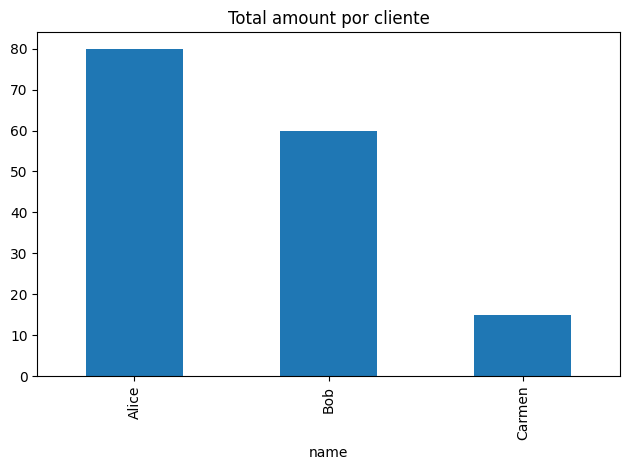

In [12]:
pdf = agg.toPandas()
print(pdf)
import matplotlib.pyplot as plt
pdf.plot.bar(x='name', y='total_amount', legend=False)
plt.title("Total amount por cliente")
plt.tight_layout()
plt.show()


### Siguientes pasos:
1. Performance: particionado, caché, persist(), broadcast joins.
2. ETL: lectura masiva (S3 / HDFS / HTTP), limpieza de texto con UDFs / pandas UDFs.
3. MLlib: pipeline sencillo de clasificación/regresión.
4. Streaming: Structured Streaming desde archivos o sockets.
5. Optimización: explain(), spark UI, shuffle tuning.